## Human-in-the-Loop Approvals and Edits in LangGraph Workflows

### Overview

This demo introduces **human-in-the-loop (HITL)** techniques for LangGraph workflows, allowing users to **approve**, **reject**, or **edit** the state before certain actions (like tool calls) proceed. This control mechanism is vital for building safe and supervised AI systems.

In [31]:
import os
from typing import Dict
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

True

### **State Definition**

- The custom state includes:
    - `question`: str
    - `answer`: str
- `MessagesState` is inherited for managing message history.

In [61]:
class State(MessagesState):
    question: str
    answer: str

### **Workflow**

#### **Search Node**

In [62]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

llm_with_tools = llm.bind_tools([web_search])

search = ToolNode([web_search])

#### **Entry Node**
- Receives the user question and builds system and human messages.

In [63]:
def entry_point(state: State):
    question = state["question"]
    system_message = SystemMessage("You conduct web search to respond to user's questions")
    human_message = HumanMessage(question)
    messages = [system_message, human_message]
    return {"messages": messages}

#### **Agent Node**
- Binds the web search tool to the LLM.
- Invokes the LLM with the current messages.
- Updates the answer field.

In [64]:
def agent(state: State):
    messages = state["messages"]
    ai_message = llm_with_tools.invoke(messages)
    return {"messages": ai_message, "answer": ai_message.content}

#### **Router**

- If the latest message contains **tool_calls**, the workflow proceeds to `tools`.
- Otherwise, it terminates.

In [65]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

#### **Graph**

In [66]:
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("tools", search)

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")
workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)
workflow.add_edge("tools", "agent")

### **Memory**

In [67]:
memory = MemorySaver()

### **Breakpoints**

- During graph compilation, `interrupt_before=["tools"]` is specified.
- This **pauses** the workflow execution **before tools are called**.

In [68]:
graph = workflow.compile(
    interrupt_before=["tools"], 
    checkpointer=memory
)

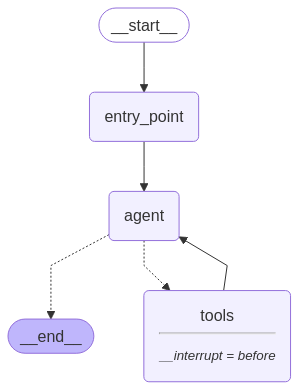

In [69]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

### **Initial example**

In [70]:
input_question = {"question": "what's the capital of Brazil?"}
config = {"configurable": {"thread_id": 1}}

In [71]:
for event in graph.stream(input=input_question, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_6yZAgXKLIJMBgj8lOdEX6OYJ)
 Call ID: call_6yZAgXKLIJMBgj8lOdEX6OYJ
  Args:
    question: What is the capital of Brazil?


In [72]:
state = graph.get_state(config=config)

In [73]:
state

StateSnapshot(values={'messages': [SystemMessage(content="You conduct web search to respond to user's questions", additional_kwargs={}, response_metadata={}, id='87620a5a-13bf-45cd-98fb-a982c5100ac2'), HumanMessage(content="what's the capital of Brazil?", additional_kwargs={}, response_metadata={}, id='40870955-4ecf-407f-818a-8ec3f25a80a2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6yZAgXKLIJMBgj8lOdEX6OYJ', 'function': {'arguments': '{"question":"What is the capital of Brazil?"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 64, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BUnn0AMv2WnQaPDoEFgr

In [74]:
state.next

('tools',)

In [75]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (call_6yZAgXKLIJMBgj8lOdEX6OYJ)
 Call ID: call_6yZAgXKLIJMBgj8lOdEX6OYJ
  Args:
    question: What is the capital of Brazil?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Brazil?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brasília - Wikipedia", "url": "https://en.wikipedia.org/wiki/Brasília", "content": "445 Region Latin America and the Caribbean Brasília (/brəˈzɪliə/ brə-ZIL-ee-ə,[4][5] Portuguese: [bɾaˈzili.ɐ, bɾaˈziljɐ] ⓘ) is the capital city of Brazil. Located in the Brazilian highlands in the country's Central-West region, it is the seat of government of the Federal District. It was founded by President Juscelino Kubitschek on 21 April 1960, to replace Rio de Janeiro as the national capital. [6] Brasília is a planned city developed by Lúcio Costa, Osc

### **Human Approval Flow**

#### a. **Basic Approval**

- A function `human_in_the_loop_run` streams the workflow.
- After seeing the agent’s intent (e.g., to call a tool), the human is prompted:
    - **YES**: Continue execution.
    - **NO**: Abort workflow.

In [76]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()
    
    human_input = input("Do you approve the tool calling? (YES or NO): ")
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    
    else:
        SystemMessage("Workflow aborted by a human").pretty_print()

In [77]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=2,
)

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_ZTGDwMCs00U2mcTMo9awrkXY)
 Call ID: call_ZTGDwMCs00U2mcTMo9awrkXY
  Args:
    question: What is the capital of Brazil?
================================ System Message ================================

Workflow aborted by a human


In [78]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Mexico?",
    thread_id=3,
)

================================ Human Message =================================

what's the capital of Mexico?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_7fk4vXFsmT35n4gDcarYd3bm)
 Call ID: call_7fk4vXFsmT35n4gDcarYd3bm
  Args:
    question: capital of Mexico
================================== Ai Message ==================================
Tool Calls:
  web_search (call_7fk4vXFsmT35n4gDcarYd3bm)
 Call ID: call_7fk4vXFsmT35n4gDcarYd3bm
  Args:
    question: capital of Mexico
================================= Tool Message =================================
Name: web_search

{"query": "capital of Mexico", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Mexico City | Population, Weather, Attractions, Culture, & History ...", "url": "https://www.britannica.com/place/Mexico-City", "content": "Mexico City is the capital of Mexico and is synonymous with the country’s Federal District. The term

#### b. **Human Revision**

- Workflow is modified to interrupt **before the agent** instead of tools.
- If the user says **NO** to the initial question:
    - They are prompted to **edit the question**.
    - A system message ("Workflow edited by a human") and a new human message are inserted.

In [79]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["agent"], 
    checkpointer=memory
)

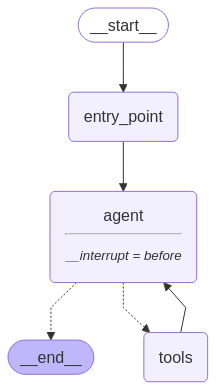

In [80]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [81]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you want to proceed with this question? (YES or NO): ")
    
    if human_input.lower() == "no":
        human_input = input("So what should be the question? ")
        human_message = HumanMessage(content=human_input)
        system_message = SystemMessage("Workflow edited by a human")
        system_message.pretty_print()
        graph.update_state(
            config=config,
            values={
                "messages": [
                    system_message,
                    human_message,
                ]
            },
        )

        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    
    for event in graph.stream(input=None, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()


In [82]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=4,
)

================================ Human Message =================================

what's the capital of Brazil?
================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_MaFLVfEvOWw50ogsS8RDHbmx)
 Call ID: call_MaFLVfEvOWw50ogsS8RDHbmx
  Args:
    question: What is the capital of Brazil?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Brazil?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brasília - Wikipedia", "url": "https://en.wikipedia.org/wiki/Brasília", "content": "445 Region Latin America and the Caribbean Brasília (/brəˈzɪliə/ brə-ZIL-ee-ə,[4][5] Portuguese: [bɾaˈzili.ɐ, bɾaˈziljɐ] ⓘ) is the capital city of Brazil. Located in the Brazilian highlands in the country's Central-West region, it is th

In [83]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=5,
)

================================ Human Message =================================

what's the capital of Brazil?
================================ System Message ================================

Workflow edited by a human
================================ Human Message =================================

capital of mexico
================================== Ai Message ==================================
Tool Calls:
  web_search (call_8Uc5yukulrCnspoio5UwsreN)
 Call ID: call_8Uc5yukulrCnspoio5UwsreN
  Args:
    question: capital of Mexico
================================= Tool Message =================================
Name: web_search

{"query": "capital of Mexico", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Mexico City | Population, Weather, Attractions, Culture, & History ...", "url": "https://www.britannica.com/place/Mexico-City", "content": "Mexico City is the capital of Mexico and is synonymous with the country’s Federal District. The term Mexico C

### **Conclusion**

- **Breakpoints** allow controlled interruptions during workflows.
- **Human approvals** ensure critical actions (like external API calls) can be supervised.
- **Human edits** allow correction of user input before significant processing happens.
- **Thread IDs** manage session persistence, enabling inspection and modification across sessions.

- Human-in-the-loop mechanisms enhance AI system transparency and safety.
- LangGraph’s breakpoint and checkpoint features make integrating HITL workflows straightforward.
- A next enhancement would be **extending approval loops after tool messages**, enabling full-cycle human supervision.